# Brain Tumor Classification Using CNN 🧠

In [ ]:
#Import all required packages
import os
import tensorflow
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from keras.utils.vis_utils import plot_model
#building hyperparameter tuning
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Load the Drive helper and mount, this was used as the code was developed in colab pulling files from google drive.  
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing 

In [ ]:
# one hot encoding the target 
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

# 0- no tumor(Normal) 

# 1- Tumor

OneHotEncoder()

In [ ]:
# image preprocessing for tumor images

data = []
paths = []
result = []
# change the directory to your own
for r, d, f in os.walk("/content/drive/MyDrive/DL/yes"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
        

In [ ]:
# image preprocessing for no tumor images

paths = []

for r, d, f in os.walk("/content/drive/MyDrive/DL/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [ ]:
#format the data and check shape 
data = np.array(data)
data.shape

(1010, 128, 128, 3)

In [ ]:
result = np.array(result)
result = result.reshape(1010,2)

In [ ]:
#data steps

In [ ]:
# split into train and test set
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [ ]:
# data normalization

x_valid, x_train = x_train[:250] / 255 , x_train[250:] / 255
y_valid, y_train = y_train[:250], y_train[250:]
x_test = x_test / 255.

In [ ]:
print(x_valid.shape)
print(y_valid.shape)
print(y_train.shape)
print(x_test.shape)
print(x_train.shape)

(250, 128, 128, 3)
(250, 2)
(558, 2)
(202, 128, 128, 3)
(558, 128, 128, 3)


# Build the CNN Neural Network

In [ ]:

#Original architecture tested

model1 = Sequential()

model1.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model1.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model1.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(2, activation='softmax'))



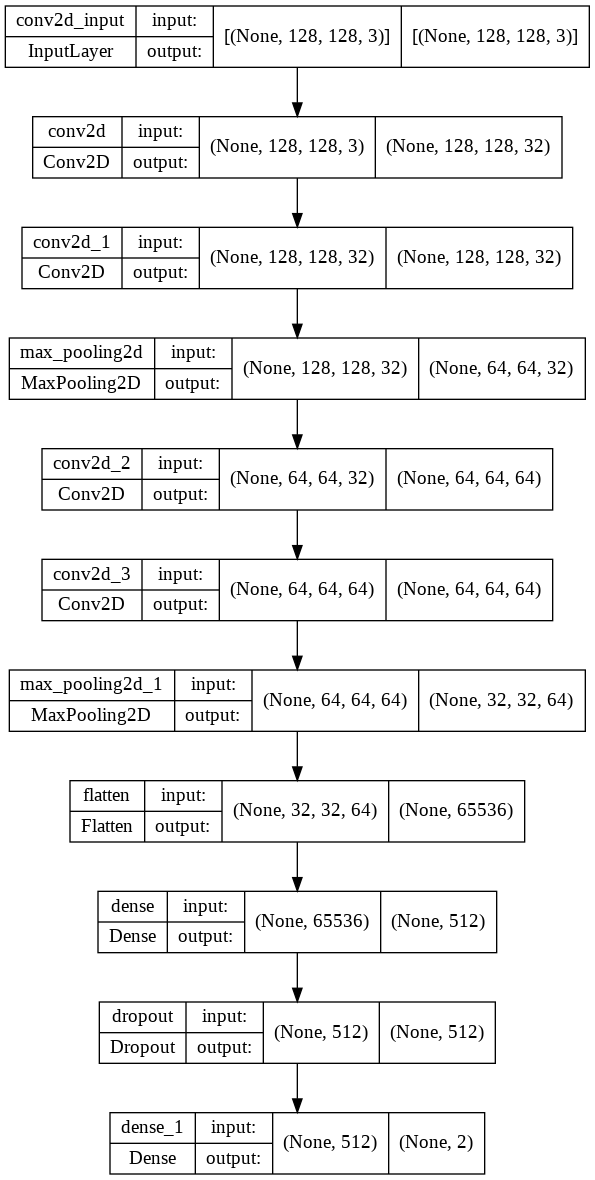

In [ ]:
#visualise the model architecture. 
plot_model(model1, show_shapes=True, show_layer_names=True)

In [ ]:

#Selected architecture found from testing numerous different permutations. We will hyperparamter tune this architecture. 
input_shape=(128, 128, 3)
model2 = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
   
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])


optimizer = keras.optimizers.Adam(lr=0.001)
model2.compile(loss = "categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
print(model2.summary())

history = model2.fit(x_train, y_train, epochs = 10, verbose = 1,validation_data = (x_valid, y_valid))

score = model2.evaluate(x_test, y_test)
### accuracy: 0.9010


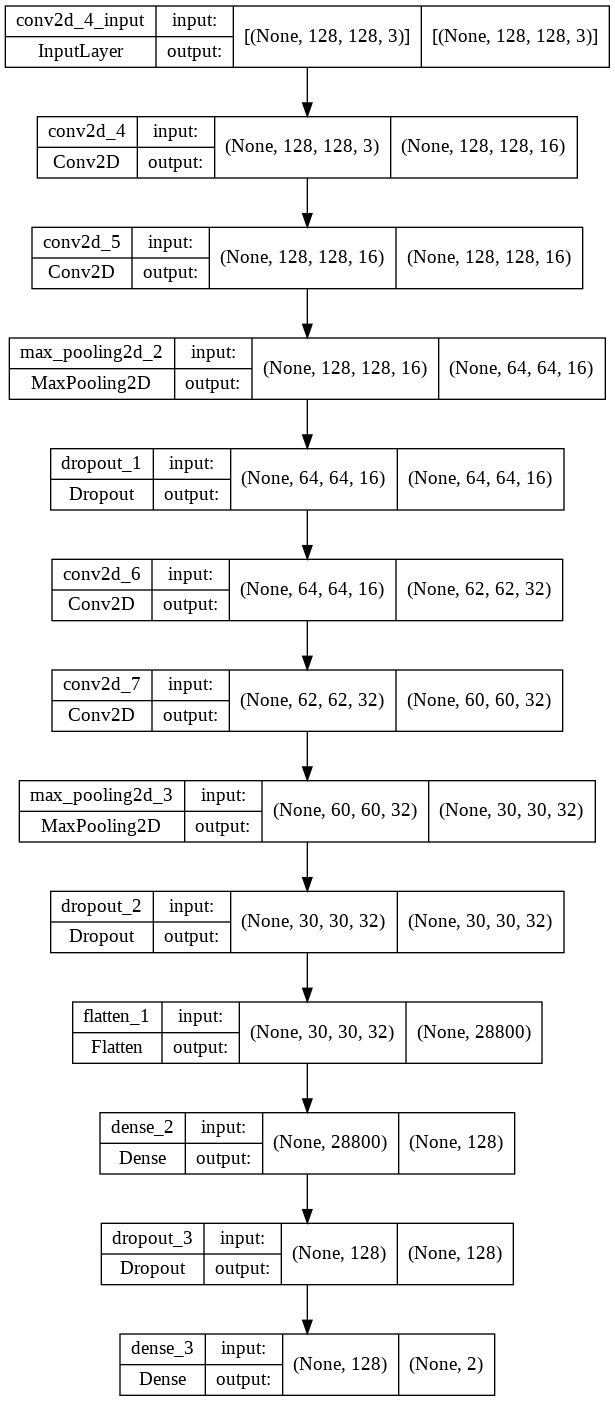

In [ ]:
#visualise the architecture. 
plot_model(model2, show_shapes=True, show_layer_names=True)

In [ ]:
#Here we create a function to define the chosen model architecture. This is used to be abel to do a hyperparamter tuning step. 

def create_model(optimizer='keras.optimizers.Adam(lr=0.001)', init='glorot_uniform'):
	# create model
    input_shape=(128, 128, 3)
    model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape, kernel_initializer=init),
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same', kernel_initializer=init),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=init),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=init),
   
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=init),
    Dropout(0.2),
    Dense(2, activation='softmax')])
	# Compile model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
#Tuning step 

#Here we specify the hyperparamters that we will test. 
model=KerasClassifier(build_fn=create_model, verbose=0)
optimizers=["adam","adamax","SGD","RMSprop"]
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [20,30,40]

#Note that we used a random search  method with 5 fold cross validation.  
distributions = dict(optimizer=optimizers, epochs=epochs, init=init)
rand = RandomizedSearchCV(model, distributions, n_iter=20)
rand_result = rand.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
#Print the best results for the selected model from hyperparamter tuning. 
rand_result.best_params_

{'epochs': 40, 'init': 'normal', 'optimizer': 'adam'}

Following hyperparamter tuning we train the model with the above outlined hyperparamters. 

In [ ]:
input_shape=(128, 128, 3)
Final_model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape, kernel_initializer='uniform'),
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same', kernel_initializer='uniform'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='uniform'),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='uniform'),
   
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='uniform'),
    Dropout(0.2),
    Dense(2, activation='softmax')])


Final_model.compile(loss = "categorical_crossentropy", optimizer='adam' , metrics=["accuracy"])
print(Final_model.summary())

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_412 (Conv2D)         (None, 128, 128, 16)      448       
                                                                 
 conv2d_413 (Conv2D)         (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_206 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_307 (Dropout)       (None, 64, 64, 16)        0         
                                                                 
 conv2d_414 (Conv2D)         (None, 62, 62, 32)        4640      
                                                                 
 conv2d_415 (Conv2D)         (None, 60, 60, 32)        9248      
                                                    

In [ ]:
# fit the model
history = Final_model.fit(x_train, y_train, epochs = 40, verbose = 1,validation_data = (x_valid, y_valid))


Epoch 1/40
18/18 [==============================] - 1s 63ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.2785 - val_accuracy: 0.8320
Epoch 2/40
18/18 [==============================] - 1s 53ms/step - loss: 0.0026 - accuracy: 0.9982 - val_loss: 1.2402 - val_accuracy: 0.8600
Epoch 3/40
18/18 [==============================] - 1s 54ms/step - loss: 0.0066 - accuracy: 0.9982 - val_loss: 1.1222 - val_accuracy: 0.8360
Epoch 4/40
18/18 [==============================] - 1s 55ms/step - loss: 0.0071 - accuracy: 0.9964 - val_loss: 1.1881 - val_accuracy: 0.8320
Epoch 5/40
18/18 [==============================] - 1s 55ms/step - loss: 0.0066 - accuracy: 0.9964 - val_loss: 1.2748 - val_accuracy: 0.8560
Epoch 6/40
18/18 [==============================] - 1s 54ms/step - loss: 0.0132 - accuracy: 0.9964 - val_loss: 1.2262 - val_accuracy: 0.8640
Epoch 7/40
18/18 [==============================] - 1s 54ms/step - loss: 0.0086 - accuracy: 0.9964 - val_loss: 1.1853 - val_accuracy: 0.8360
Epoch 8/40
18

In [ ]:
score = Final_model.evaluate(x_test, y_test)


7/7 [==============================] - 0s 37ms/step - loss: 1.0517 - accuracy: 0.8762


# Prediction 

In [ ]:
def names(number):
    if number==0:
        return 'No Tumor detected'
    else:
        return 'Tumor detected'


In [ ]:
from matplotlib.pyplot import imshow
img = Image.open("/content/drive/MyDrive/DL/new/Cancer (1).jpg")# never seen image of brain with a tumor

x = np.array(img.resize((128,128)))

x = x.reshape(1,128,128,3)




###  Model 2 is used for the prediciton because it had overall better performance compared to tuned model

100.0% Confidence Tumor detected


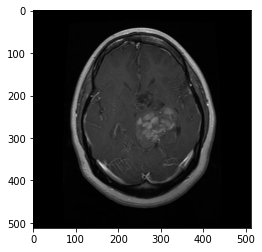

In [ ]:
res = model2.predict(x)

classification = np.where(res == np.amax(res))[1][0]

imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open("/content/drive/MyDrive/DL/new/Not Cancer  (4).jpg")  # never seen image of brain with no tumor

x = np.array(img.resize((128,128)))

x = x.reshape(1,128,128,3)




100.0% Confidence No Tumor detected


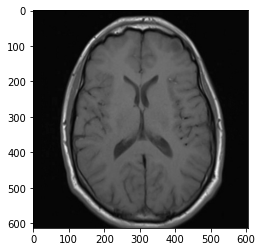

In [ ]:
res = model2.predict(x)

classification = np.where(res == np.amax(res))[1][0]

imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))